In [1]:
# ====== DRIVER FATIGUE DETECTION TRAINING - GOOGLE COLAB ======

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/driver_fatigue_detection.zip'
extract_path = '/content/driver_fatigue_detection'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Now change directory to the extracted folder
os.chdir(extract_path)

# Confirm where you are
print("Current directory:", os.getcwd())

Current directory: /content/driver_fatigue_detection


In [6]:
# Install dependencies
!pip install tensorflow opencv-python scikit-learn matplotlib seaborn pyyaml

In [7]:
# Check GPU availability
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0


In [8]:
# ====== IMPORT LIBRARIES ======
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import yaml

In [17]:
import os

npy_files = []
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('.npy'):
            npy_files.append(os.path.join(root, file))

# Print first 50 .npy file paths
for path in npy_files[:50]:
    print(path)

./driver_fatigue_detection/fatigue/Lib/site-packages/scipy/stats/tests/data/jf_skew_t_gamlss_pdf_data.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/scipy/stats/tests/data/rel_breitwigner_pdf_sample_data_ROOT.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/scipy/stats/tests/data/levy_stable/stable-Z1-pdf-sample-data.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/scipy/stats/tests/data/levy_stable/stable-Z1-cdf-sample-data.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/scipy/stats/tests/data/levy_stable/stable-loc-scale-sample-data.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/scipy/interpolate/tests/data/estimate_gradients_hang.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/matplotlib/mpl-data/sample_data/axes_grid/bivariate_normal.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/numpy/lib/tests/data/win64python2.npy
./driver_fatigue_detection/fatigue/Lib/site-packages/numpy/lib/tests/data/py3-objarr.npy
./driver_fatig

In [14]:
# ====== LOAD CONFIGURATION ======
with open('./driver_fatigue_detection/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [18]:
# ====== LOAD DATA ======
print("Loading preprocessed data...")

X_train = np.load('./driver_fatigue_detection/data/splits/X_train.npy')
y_train = np.load('./driver_fatigue_detection/data/splits/y_train.npy')
X_val = np.load('./driver_fatigue_detection/data/splits/X_val.npy')
y_val = np.load('./driver_fatigue_detection/data/splits/y_val.npy')
X_test = np.load('./driver_fatigue_detection/data/splits/X_test.npy')
y_test = np.load('./driver_fatigue_detection/data/splits/y_test.npy')

print(f"Data loaded:")
print(f"  Train: {X_train.shape}, {y_train.shape}")
print(f"  Validation: {X_val.shape}, {y_val.shape}")
print(f"  Test: {X_test.shape}, {y_test.shape}")

Loading preprocessed data...
Data loaded:
  Train: (35511, 64, 64, 1), (35511,)
  Validation: (10146, 64, 64, 1), (10146,)
  Test: (5074, 64, 64, 1), (5074,)


In [19]:
# ====== CREATE LIGHTWEIGHT MODEL FOR COLAB ======
def create_lightweight_model():
    """Optimized model for Colab training"""
    model = models.Sequential([
        # First conv block
        layers.Conv2D(16, (3, 3), activation='relu',
                     input_shape=(64, 64, 1), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes: closed/open
    ])

    return model

# Create and compile model
model = create_lightweight_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,610 (64.88 KB)

 Trainable params: 16,450 (64.26 KB)

 Non-trainable params: 160 (640.00 B)

In [20]:
# ====== DATA AUGMENTATION ======
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Create data generators
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [21]:
# ====== TRAINING CALLBACKS ======
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        filepath='/content/drive/MyDrive/best_fatigue_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [22]:

# ====== START TRAINING ======
print("Starting training...")
print("⚠️  Keep this tab active to prevent disconnection!")

# Train for fewer epochs initially due to time constraints
epochs = 30  # Reduced for Colab free tier

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training...
⚠️  Keep this tab active to prevent disconnection!
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6921 - loss: 0.5821
Epoch 1: val_accuracy improved from -inf to 0.80436, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.6922 - loss: 0.5820 - val_accuracy: 0.8044 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 2/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8213 - loss: 0.3935
Epoch 2: val_accuracy did not improve from 0.80436
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.8213 - loss: 0.3934 - val_accuracy: 0.7786 - val_loss: 0.4906 - learning_rate: 0.0010
Epoch 3/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8669 - loss: 0.3084
Epoch 3: val_accuracy improved from 0.80436 to 0.88961, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8669 - loss: 0.3084 - val_accuracy: 0.8896 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 4/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8840 - loss: 0.2736
Epoch 4: val_accuracy did not improve from 0.88961
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8840 - loss: 0.2736 - val_accuracy: 0.8803 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 5/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8942 - loss: 0.2545
Epoch 5: val_accuracy did not improve from 0.88961
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8942 - loss: 0.2545 - val_accuracy: 0.8800 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 6/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9001 - loss: 0.2422
Epoch 6: val_accuracy did not improve from 0.88961
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.9001 - loss: 0.2422 - val_accuracy: 0.8667 - val_loss: 0.4017 - learning_rate: 0.0010


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9031 - loss: 0.2322 - val_accuracy: 0.9255 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 8/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9098 - loss: 0.2224
Epoch 8: val_accuracy did not improve from 0.92549
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9098 - loss: 0.2224 - val_accuracy: 0.8988 - val_loss: 0.2557 - learning_rate: 0.0010
Epoch 9/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9112 - loss: 0.2211
Epoch 9: val_accuracy improved from 0.92549 to 0.92578, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9112 - loss: 0.2211 - val_accuracy: 0.9258 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 10/30
1108/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9109 - loss: 0.2141
Epoch 10: val_accuracy improved from 0.92578 to 0.93465, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9109 - loss: 0.2140 - val_accuracy: 0.9347 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 11/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9119 - loss: 0.2104
Epoch 11: val_accuracy did not improve from 0.93465
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9119 - loss: 0.2104 - val_accuracy: 0.9186 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 12/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9164 - loss: 0.2052
Epoch 12: val_accuracy did not improve from 0.93465
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9164 - loss: 0.2052 - val_accuracy: 0.8675 - val_loss: 0.2799 - learning_rate: 0.0010
Epoch 13/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9206 - loss: 0.1986
Epoch 13: val_accuracy improved from 0.93465 to 0.93870, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9206 - loss: 0.1986 - val_accuracy: 0.9387 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 14/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9196 - loss: 0.1982
Epoch 14: val_accuracy did not improve from 0.93870
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9196 - loss: 0.1982 - val_accuracy: 0.7990 - val_loss: 0.7343 - learning_rate: 0.0010
Epoch 15/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9181 - loss: 0.1966
Epoch 15: val_accuracy did not improve from 0.93870
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9181 - loss: 0.1966 - val_accuracy: 0.9179 - val_loss: 0.1944 - learning_rate: 0.0010
Epoch 16/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9239 - loss: 0.1893
Epoch 16: val_accuracy improved from 0.93870 to 0.94648, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9239 - loss: 0.1893 - val_accuracy: 0.9465 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 17/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9209 - loss: 0.1929
Epoch 17: val_accuracy did not improve from 0.94648
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9209 - loss: 0.1929 - val_accuracy: 0.8702 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 18/30
1108/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9209 - loss: 0.1926
Epoch 18: val_accuracy did not improve from 0.94648
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9209 - loss: 0.1926 - val_accuracy: 0.9172 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 19/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9263 - loss: 0.1849
Epoch 19: val_accuracy did not improve from 0.94648
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9263 - loss: 0.1849 - val_accuracy: 0.8816 - val_loss: 0.2913 - learning_rate: 0

1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9345 - loss: 0.1609 - val_accuracy: 0.9468 - val_loss: 0.1276 - learning_rate: 5.0000e-04
Epoch 27/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9347 - loss: 0.1596
Epoch 27: val_accuracy did not improve from 0.94678
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9347 - loss: 0.1596 - val_accuracy: 0.9166 - val_loss: 0.2028 - learning_rate: 5.0000e-04
Epoch 28/30
1109/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9336 - loss: 0.1662
Epoch 28: val_accuracy did not improve from 0.94678
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9336 - loss: 0.1662 - val_accuracy: 0.9342 - val_loss: 0.1663 - learning_rate: 5.0000e-04
Epoch 29/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9351 - loss: 0.1573
Epoch 29: val_accuracy improved from 0.94678 to 0.94944, saving model to /content/drive/MyDrive/best_fatigue_model.h5


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9351 - loss: 0.1573 - val_accuracy: 0.9494 - val_loss: 0.1184 - learning_rate: 5.0000e-04
Epoch 30/30
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9358 - loss: 0.1585
Epoch 30: val_accuracy did not improve from 0.94944
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9358 - loss: 0.1585 - val_accuracy: 0.9350 - val_loss: 0.1470 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 29.
Training completed!


In [23]:
# ====== EVALUATE MODEL ======
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Results:
Test Loss: 0.1153
Test Accuracy: 0.9505


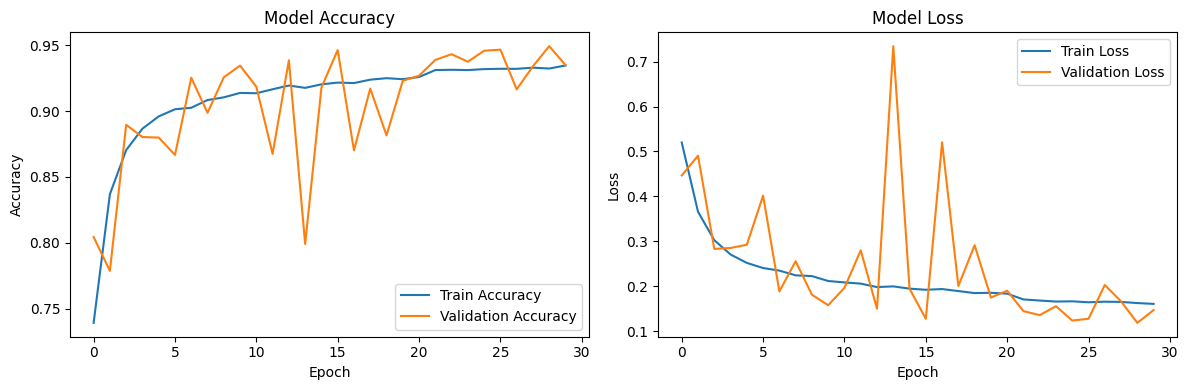

In [24]:
# ====== PLOT TRAINING HISTORY ======
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# ====== CONVERT TO TENSORFLOW LITE ======
print("Converting to TensorFlow Lite for Raspberry Pi...")

# Load the best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/best_fatigue_model.h5')

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Apply quantization for smaller model size
tflite_model = converter.convert()

# Save TensorFlow Lite model
tflite_path = '/content/drive/MyDrive/fatigue_detector.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Check model size
import os
model_size_kb = os.path.getsize(tflite_path) / 1024
print(f"TensorFlow Lite model saved!")
print(f"Model size: {model_size_kb:.2f} KB")

Converting to TensorFlow Lite for Raspberry Pi...


Saved artifact at '/tmp/tmptfzd14ou'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137223024182864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024184592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024183056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024185168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024182672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024184400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024184016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024187088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024187472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024188048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137223024186128: 

In [26]:
# ====== DOWNLOAD MODELS ======
from google.colab import files

print("Downloading trained models...")
files.download('/content/drive/MyDrive/best_fatigue_model.h5')
files.download('/content/drive/MyDrive/fatigue_detector.tflite')

print("🎉 Training completed successfully!")
print("Models saved to Google Drive and downloaded to your computer.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎉 Training completed successfully!
Models saved to Google Drive and downloaded to your computer.
